In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
# Suppression des avertissements pour une sortie plus propre
warnings.filterwarnings('ignore')

## Data loading
chargement du dataset flights.csv

In [ ]:
try:
    df = pd.read_csv('/content/drive/MyDrive/ECOLE-IT/4DIA/flights.csv')
    display(df.head())
except FileNotFoundError:
    print("Error: 'flights.csv' not found. Please ensure the file exists in the current directory.")
    df = None # Mettre df à None pour indiquer l'échec
except pd.errors.ParserError:
    print("Error: Could not parse 'flights.csv'. Please check the file format.")
    df = None

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


## Exploration des données

Explorer l'ensemble des données de vol chargées afin de comprendre leur structure, d'identifier les problèmes potentiels et d'obtenir des informations initiales.

In [ ]:
df.shape

(5819079, 31)

In [ ]:
df.columns

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'],
      dtype='object')

In [ ]:
# Data Shape
print("Data Shape:", df.shape)

# Data Types
print("\nData Types:\n", df.dtypes)

# Missing Values
missing_values = df.isnull().sum()
print("\nMissing Values:\n", missing_values)
missing_percentage = (missing_values / len(df)) * 100
print("\nMissing Value Percentage:\n", missing_percentage)

# Descriptive Statistics
print("\nDescriptive Statistics:\n", df.describe(include='all'))

# Categorical Feature Distribution
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"\nDistribution of {col}:\n{df[col].value_counts()}")
    print(f"Unique values in {col}: {df[col].nunique()}")

# Initial Insights
print("\nInitial Insights:")
print("1. Many columns related to delays have a significant number of missing values, which is expected for flights that were on time.")
print("2. The 'CANCELLATION_REASON' column has many missing values, which is expected for non-cancelled flights.")
print("3. Some columns like 'TAIL_NUMBER' might have a large number of unique values.")
print("4. Check for inconsistencies in date and time related columns.")
print("5. Investigate the mixed data types in columns 7 and 8.")

Data Shape: (5819079, 31)

Data Types:
 YEAR                     int64
MONTH                    int64
DAY                      int64
DAY_OF_WEEK              int64
AIRLINE                 object
FLIGHT_NUMBER            int64
TAIL_NUMBER             object
ORIGIN_AIRPORT          object
DESTINATION_AIRPORT     object
SCHEDULED_DEPARTURE      int64
DEPARTURE_TIME         float64
DEPARTURE_DELAY        float64
TAXI_OUT               float64
WHEELS_OFF             float64
SCHEDULED_TIME         float64
ELAPSED_TIME           float64
AIR_TIME               float64
DISTANCE                 int64
WHEELS_ON              float64
TAXI_IN                float64
SCHEDULED_ARRIVAL        int64
ARRIVAL_TIME           float64
ARRIVAL_DELAY          float64
DIVERTED                 int64
CANCELLED                int64
CANCELLATION_REASON     object
AIR_SYSTEM_DELAY       float64
SECURITY_DELAY         float64
AIRLINE_DELAY          float64
LATE_AIRCRAFT_DELAY    float64
WEATHER_DELAY          float64

## Generation du prix des vols

In [ ]:
def generate_price(row):
    """
    Calcule un prix de vol heuristique basé sur les caractéristiques du vol.

    Args:
        row (pd.Series): Une ligne du DataFrame contenant les informations du vol.

    Returns:
        float: Le prix heuristique calculé pour le vol.
    """
    base_price = 50.0  # Prix de base minimum pour n'importe quel vol

    # 1. Facteur Distance (colonne 'DISTANCE')
    distance = row.get('DISTANCE', 0)
    if pd.isna(distance):
        distance = 0
    price_distance_factor = distance * 0.10 # Ajustez ce facteur selon vos besoins

    # 2. Facteur Compagnie Aérienne (colonne 'AIRLINE')
    # WN: Southwest (Low-Cost/Major) -> Tendance à être moins cher
    # DL: Delta Air Lines (Major/Legacy) -> Tendance à être plus cher
    # AA: American Airlines (Major/Legacy) -> Tendance à être plus cher
    # OO: SkyWest Airlines (Regional, opère pour les majors) -> Neutre ou légèrement moins
    # EV: ExpressJet (Regional, opère pour les majors, a cessé ses opérations principales) -> Neutre/supposer comme OO
    # UA: United Airlines (Major/Legacy) -> Tendance à être plus cher
    # MQ: Envoy Air (Regional pour AA) -> Neutre ou légèrement moins
    # B6: JetBlue (Hybrid/Low-Cost avec des services premium) -> Milieu de gamme
    # US: US Airways (Fusionné avec AA, était Major/Legacy) -> Similaire à AA/DL/UA
    # AS: Alaska Airlines (Major/Hybrid) -> Milieu de gamme / légèrement supérieur
    # NK: Spirit Airlines (Ultra Low-Cost) -> Beaucoup moins cher
    # F9: Frontier Airlines (Ultra Low-Cost) -> Beaucoup moins cher
    # HA: Hawaiian Airlines (Focus sur Hawaï, peut être plus cher pour ces routes) -> Milieu/supérieur
    # VX: Virgin America (Fusionné avec AS, était Hybrid/Low-Cost branché) -> Similaire à B6/AS

    airline_multipliers = {
        'WN': 0.90, # Southwest
        'DL': 1.15, # Delta
        'AA': 1.15, # American Airlines
        'OO': 0.95, # SkyWest (Regional)
        'EV': 0.95, # ExpressJet (Regional) - même si ops changées, pour données historiques
        'UA': 1.20, # United Airlines
        'MQ': 0.95, # Envoy Air (Regional)
        'B6': 1.05, # JetBlue
        'US': 1.15, # US Airways (considérer comme legacy)
        'AS': 1.10, # Alaska Airlines
        'NK': 0.70, # Spirit Airlines
        'F9': 0.75, # Frontier Airlines
        'HA': 1.10, # Hawaiian Airlines
        'VX': 1.05, # Virgin America (considérer comme JetBlue/Alaska)
        # Multiplicateur par défaut pour toute autre compagnie non listée
    }
    airline_multiplier = airline_multipliers.get(row.get('AIRLINE'), 1.0)

    # 3. Facteur Saisonnalité (colonne 'MONTH')
    month = row.get('MONTH')
    season_multiplier = 1.0
    if pd.notna(month):
        if month in [6, 7, 8]:  # Été
            season_multiplier = 1.3
        elif month == 12 or month == 1: # Vacances de fin d'année et début d'année
            season_multiplier = 1.25
        elif month in [3,4]: # Printemps (Spring Break)
             season_multiplier = 1.15
        elif month in [10, 11]: # Automne (hors Thanksgiving)
            season_multiplier = 0.95
        elif month in [2, 5, 9]: # Basse saison relative
            season_multiplier = 0.90


    # 4. Facteur Jour de la Semaine (colonne 'DAY_OF_WEEK')
    # Lundi=1, ..., Dimanche=7 (si votre colonne est déjà comme ça)
    # Si 0-6 (Lundi-Dimanche) ou autre, ajustez les chiffres [4,6] pour Vendredi, Dimanche
    day_of_week = row.get('DAY_OF_WEEK')
    day_multiplier = 1.0
    if pd.notna(day_of_week):
        # Supposons que 1=Lundi, ..., 4=Jeudi, 5=Vendredi, 6=Samedi, 7=Dimanche
        if day_of_week in [5, 7]:  # Vendredi ou Dimanche (pics de voyage)
            day_multiplier = 1.20
        elif day_of_week == 6: # Samedi
            day_multiplier = 1.10
        elif day_of_week in [1,4]: # Lundi et Jeudi (voyages d'affaires/début de semaine)
            day_multiplier = 1.05


    # 5. Facteur Heure de Départ (colonne 'SCHEDULED_DEPARTURE')
    time_multiplier = 1.0
    scheduled_departure_time = row.get('SCHEDULED_DEPARTURE')
    if pd.notna(scheduled_departure_time):
        try:
            if isinstance(scheduled_departure_time, str):
                 if len(scheduled_departure_time) < 3:
                    hour = int(scheduled_departure_time)
                 else:
                    hour = int(str(scheduled_departure_time).zfill(4)[:2])
            else:
                hour = int(str(int(scheduled_departure_time)).zfill(4)[:2])

            if hour <= 6 or hour >= 21:  # Vols très tôt le matin ou tard le soir
                time_multiplier = 0.85
            elif 7 <= hour <= 9 or 16 <= hour <= 19 : # Heures de pointe
                time_multiplier = 1.15
        except ValueError:
            pass

    # 6. Facteur Durée du Vol (colonne 'AIR_TIME' ou 'SCHEDULED_TIME')
    air_time = row.get('AIR_TIME', row.get('SCHEDULED_TIME', 0))
    if pd.isna(air_time):
        air_time = 0
    duration_factor = 0
    if air_time > 300: # Plus de 5 heures de vol
        duration_factor = 25
    elif air_time > 180: # Plus de 3 heures
        duration_factor = 10


    # Calcul du prix final
    calculated_price = (base_price + price_distance_factor + duration_factor) * \
                       airline_multiplier * \
                       season_multiplier * \
                       day_multiplier * \
                       time_multiplier

    random_factor = np.random.uniform(0.95, 1.05)
    final_price = calculated_price * random_factor

    return round(max(final_price, 25.0), 2) # Prix minimum de 25€

def add_genereted_price_column(df):
    """
    Ajoute une colonne 'PREDICTED_PRICE' au DataFrame en utilisant la fonction heuristique.

    Args:
        df (pd.DataFrame): Le DataFrame des vols.

    Returns:
        pd.DataFrame: Le DataFrame avec la colonne 'PREDICTED_PRICE' ajoutée.
    """
    if 'DISTANCE' not in df.columns:
        raise ValueError("La colonne 'DISTANCE' est requise pour le calcul du prix.")
    # Des avertissements peuvent être ajoutés pour d'autres colonnes si nécessaire

    df_copy = df.copy()
    df_copy['PREDICTED_PRICE'] = df_copy.apply(generate_price, axis=1)
    return df_copy

In [ ]:
df = add_genereted_price_column(df.copy())

In [ ]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,PREDICTED_PRICE
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,235.35
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,392.63
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,389.78
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,392.03
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,240.79


## Nettoyage des données

Nettoyer les données de vol en traitant les valeurs manquantes et en supprimant les colonnes non pertinantes pour notre cas d'application.

In [ ]:
# Liste des colones importantes
necessary_columns = [
    'YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'AIR_TIME', 'FLIGHT_NUMBER',
    'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE',
    'SCHEDULED_ARRIVAL', 'SCHEDULED_TIME', 'DISTANCE', 'PREDICTED_PRICE'
]

# Vérifier si toutes les colonnes nécessaires existent
missing_cols = [col for col in necessary_columns if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing columns: {missing_cols}")

# Supprimer les lignes annulées ou détournées
df = df[(df['CANCELLED'] == 0) & (df['DIVERTED'] == 0)]

# Sélectionner uniquement les colonnes nécessaires
df = df[necessary_columns]

# Valider les données
for col in necessary_columns:
    if df[col].isna().sum() > 0:
        print(f"Warning: {df[col].isna().sum()} missing values in {col}. Dropping affected rows.")
        df = df.dropna(subset=[col])

display(df.head())

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,AIR_TIME,FLIGHT_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,SCHEDULED_TIME,DISTANCE,PREDICTED_PRICE
0,2015,1,1,4,AS,169.0,98,ANC,SEA,5,430,205.0,1448,235.35
1,2015,1,1,4,AA,263.0,2336,LAX,PBI,10,750,280.0,2330,392.63
2,2015,1,1,4,US,266.0,840,SFO,CLT,20,806,286.0,2296,389.78
3,2015,1,1,4,AA,258.0,258,LAX,MIA,20,805,285.0,2342,392.03
4,2015,1,1,4,AS,199.0,135,SEA,ANC,25,320,235.0,1448,240.79


In [ ]:
df.shape

(5714008, 14)

## Exportation du dataset enrichi en csv

In [ ]:
output_csv = "/content/drive/MyDrive/ECOLE-IT/4DIA/enriched_and_cleaned_dataset.csv"
df.to_csv(output_csv, index=False)

## Analyse des données
Effectuer une analyse détaillée des données sur l'ensemble des données de vol nettoyées.

Descriptive Statistics for Numerical Columns:


,DISTANCE,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,SCHEDULED_TIME,AIR_TIME,PREDICTED_PRICE
count,5.714008e+06,5.714008e+06,5.714008e+06,5.714008e+06,5.714008e+06,5.714008e+06
mean,8.244569e+02,1.328907e+03,1.493187e+03,1.418940e+02,1.135116e+02,1.767042e+02
std,6.086620e+02,4.835251e+02,5.069011e+02,7.531400e+01,7.223082e+01,1.052874e+02
min,3.100000e+01,1.000000e+00,1.000000e+00,1.800000e+01,7.000000e+00,3.454000e+01
25%,3.730000e+02,9.160000e+02,1.110000e+03,8.500000e+01,6.000000e+01,1.047000e+02
50%,6.500000e+02,1.325000e+03,1.520000e+03,1.230000e+02,9.400000e+01,1.452600e+02
75%,1.065000e+03,1.730000e+03,1.917000e+03,1.740000e+02,1.440000e+02,2.135400e+02
max,4.983000e+03,2.359000e+03,2.400000e+03,7.180000e+02,6.900000e+02,1.289950e+03



Distribution of Categorical Features:

AIRLINE:
AIRLINE
WN    21.743109
DL    15.230553
AA    12.476969
OO    10.094736
EV     9.708632
UA     8.886267
MQ     4.879080
B6     4.585958
US     3.399068
AS     3.000328
NK     2.015975
F9     1.576652
HA     1.330782
VX     1.071892
Name: proportion, dtype: float64


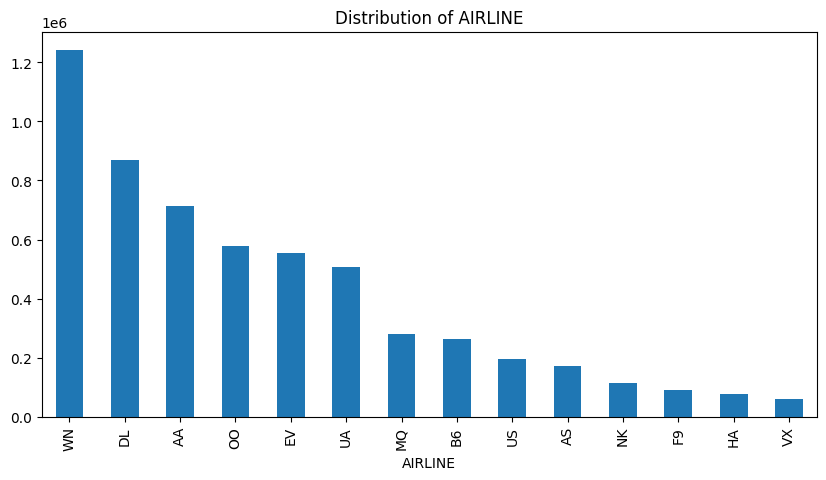


ORIGIN_AIRPORT:
ORIGIN_AIRPORT
ATL      6.011647
ORD      4.839930
DFW      4.071520
DEN      3.384699
LAX      3.360216
           ...   
11503    0.000018
14025    0.000018
13502    0.000018
15497    0.000018
12265    0.000018
Name: proportion, Length: 929, dtype: float64


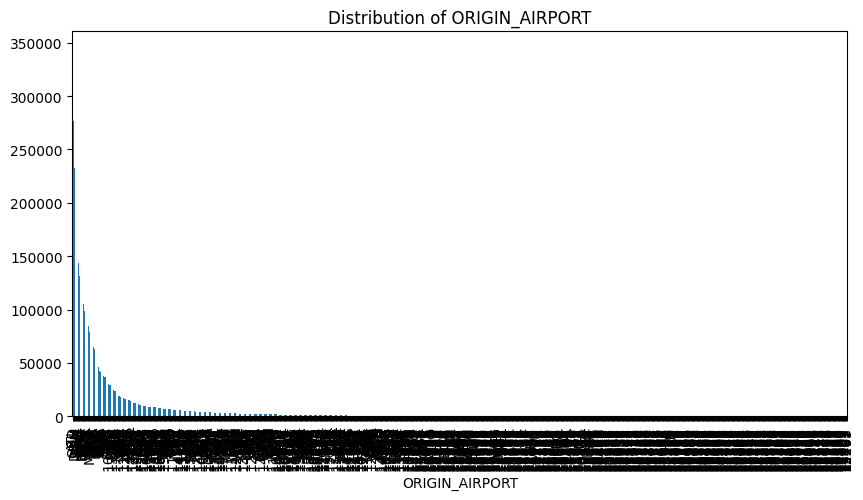


DESTINATION_AIRPORT:
DESTINATION_AIRPORT
ATL      6.004122
ORD      4.827855
DFW      4.056067
DEN      3.378242
LAX      3.362543
           ...   
11097    0.000018
14222    0.000018
13459    0.000018
12265    0.000018
10666    0.000018
Name: proportion, Length: 929, dtype: float64


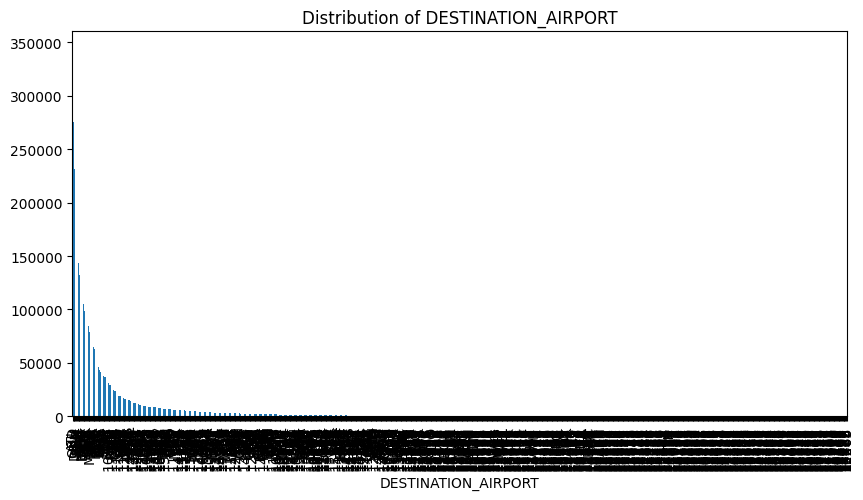


Correlation Matrix:


,DISTANCE,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,SCHEDULED_TIME,AIR_TIME,PREDICTED_PRICE
DISTANCE,1.000000,-0.008854,0.027675,0.984438,0.985643,0.896089
SCHEDULED_DEPARTURE,-0.008854,1.000000,0.705042,-0.015846,-0.015756,-0.000291
SCHEDULED_ARRIVAL,0.027675,0.705042,1.000000,0.032322,0.029698,0.072967
SCHEDULED_TIME,0.984438,-0.015846,0.032322,1.000000,0.990749,0.894402
AIR_TIME,0.985643,-0.015756,0.029698,0.990749,1.000000,0.888867
PREDICTED_PRICE,0.896089,-0.000291,0.072967,0.894402,0.888867,1.000000


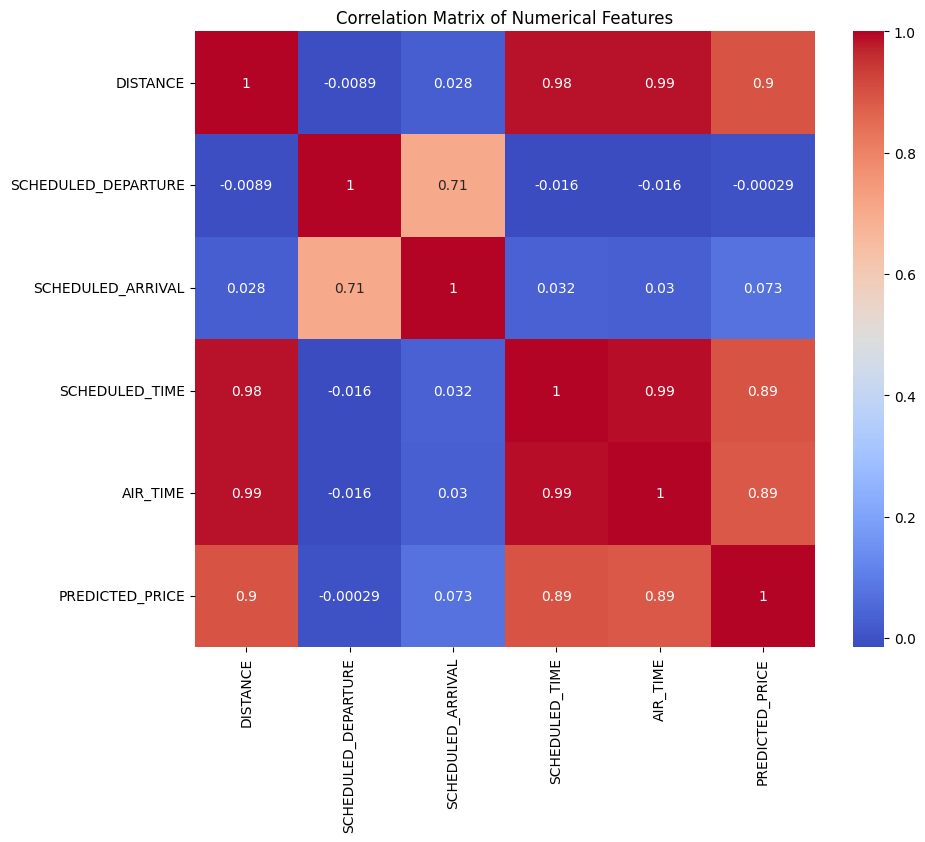


Relationship between Airline and Departure Delay:


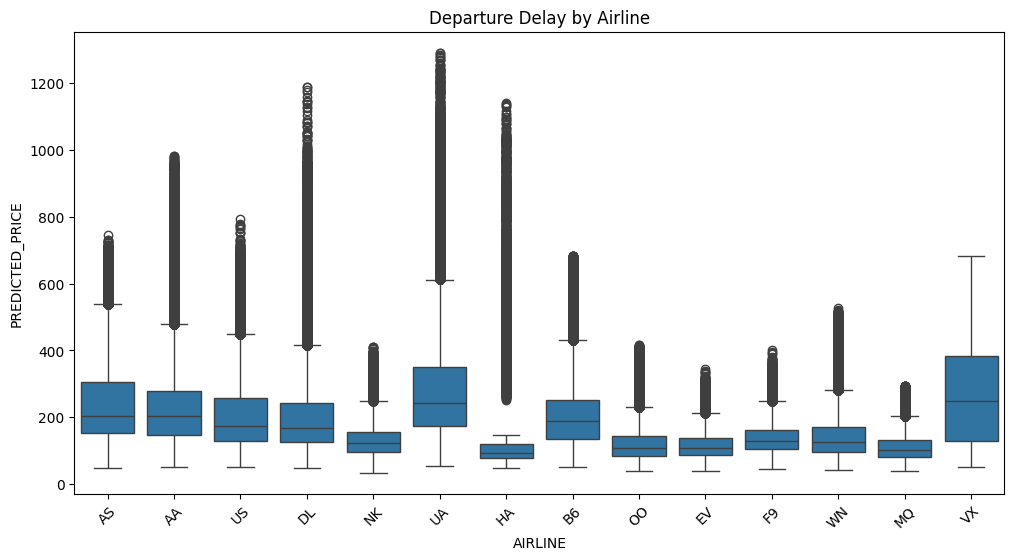


Relationship between Distance and Arrival Delay:


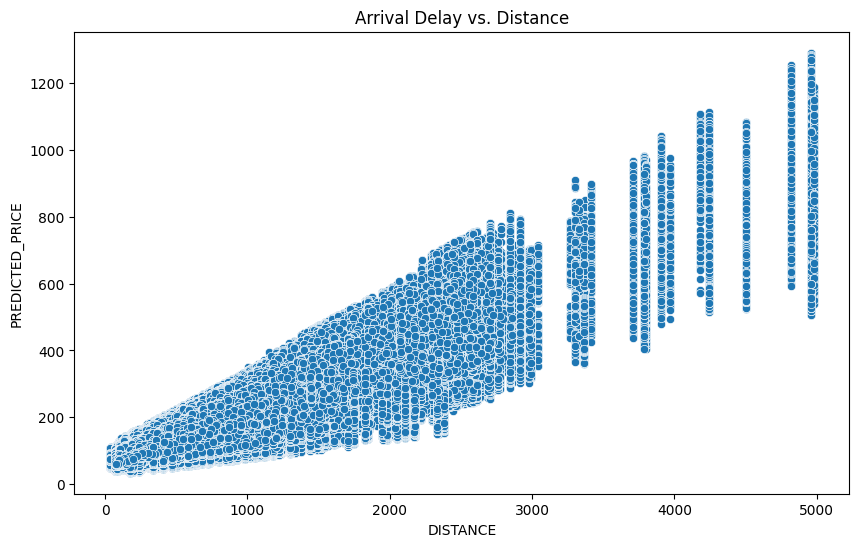

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Descriptive Statistics
numerical_cols = ['DISTANCE', 'SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'SCHEDULED_TIME', 'AIR_TIME', 'PREDICTED_PRICE']
print("Descriptive Statistics for Numerical Columns:")
display(df[numerical_cols].describe())

# Categorical Feature Analysis
categorical_cols = ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']
print("\nDistribution of Categorical Features:")
for col in categorical_cols:
    print(f"\n{col}:")
    print(df[col].value_counts(normalize=True) * 100) # Display as percentage
    plt.figure(figsize=(10, 5))
    df[col].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {col}')
    plt.show()

# Correlation Analysis
correlation_matrix = df[numerical_cols].corr()
print("\nCorrelation Matrix:")
display(correlation_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Relationship Exploration
print("\nRelationship between Airline and Departure Delay:")
plt.figure(figsize=(12, 6))
sns.boxplot(x='AIRLINE', y='PREDICTED_PRICE', data=df)
plt.title('Departure Delay by Airline')
plt.xticks(rotation=45)
plt.show()

print("\nRelationship between Distance and Arrival Delay:")
plt.figure(figsize=(10, 6))
sns.scatterplot(x='DISTANCE', y='PREDICTED_PRICE', data=df)
plt.title('Arrival Delay vs. Distance')
plt.show()

## Visualisation des données

Visualisez les aspects clés des données de vol afin d'obtenir des informations supplémentaires.

In [ ]:
# Set Seaborn style for better aesthetics
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# 1. Price Distribution by Airline (Boxplot)
plt.figure()
sns.boxplot(x='AIRLINE', y='PREDICTED_PRICE', data=df, order=['WN', 'DL', 'AA', 'OO', 'EV', 'UA', 'MQ', 'B6', 'US', 'AS', 'NK', 'F9', 'HA', 'VX'])
plt.title('Price Distribution by Airline')
plt.xlabel('Airline')
plt.ylabel('Generated Price ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('price_by_airline.png')
plt.close()
print("Saved: price_by_airline.png")

# 2. Average Price by Month (Bar Plot)
plt.figure()
monthly_avg = df.groupby('MONTH')['PREDICTED_PRICE'].mean().reset_index()
sns.barplot(x='MONTH', y='PREDICTED_PRICE', data=monthly_avg)
plt.title('Average Price by Month')
plt.xlabel('Month')
plt.ylabel('Average Generated Price ($)')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.savefig('price_by_month.png')
plt.close()
print("Saved: price_by_month.png")

# 3. Flight Duration vs. Distance (Scatter Plot)
plt.figure()
sns.scatterplot(x='DISTANCE', y='AIR_TIME', hue='AIRLINE', data=df, alpha=0.6)
plt.title('Flight Duration vs. Distance by Airline')
plt.xlabel('Distance (miles)')
plt.ylabel('Air Time (minutes)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('duration_vs_distance.png')
plt.close()
print("Saved: duration_vs_distance.png")

# 4. Price vs. Day of Week (Boxplot)
plt.figure()
sns.boxplot(x='DAY_OF_WEEK', y='PREDICTED_PRICE', data=df)
plt.title('Price Distribution by Day of Week')
plt.xlabel('Day of Week (1=Mon, 7=Sun)')
plt.ylabel('Generated Price ($)')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.tight_layout()
plt.savefig('price_by_day_of_week.png')
plt.close()
print("Saved: price_by_day_of_week.png")

Saved: price_by_airline.png
Saved: price_by_month.png
Saved: duration_vs_distance.png
Saved: price_by_day_of_week.png


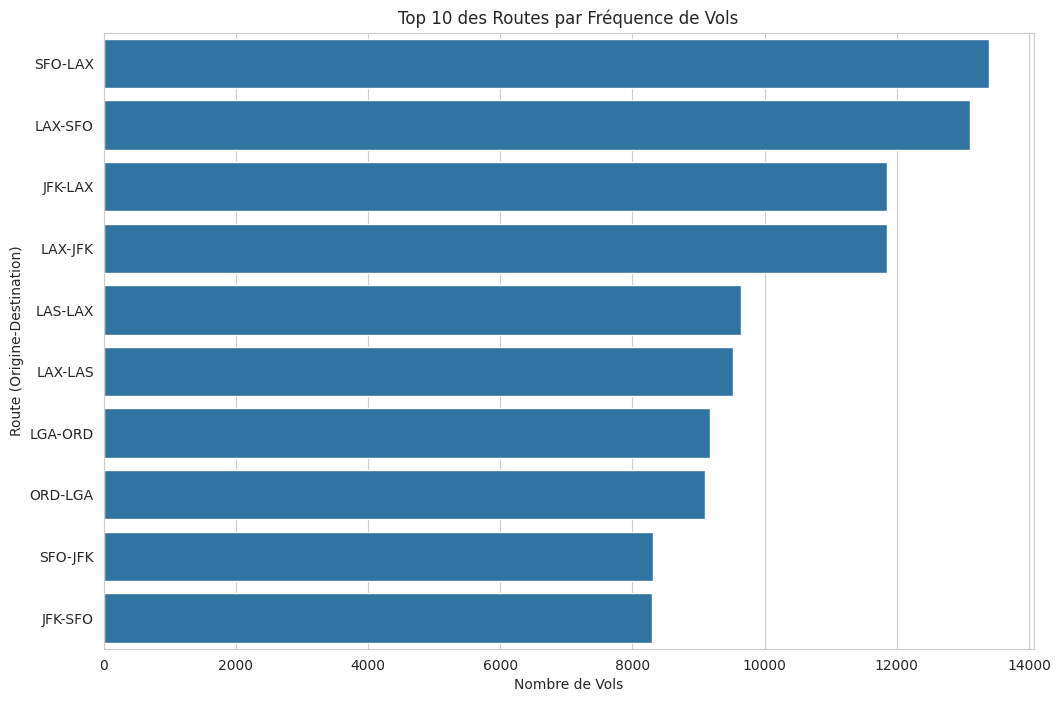

In [ ]:
df['route'] = df['ORIGIN_AIRPORT'].astype(str) + '-' + df['DESTINATION_AIRPORT'].astype(str)
top_routes = df['route'].value_counts().head(10)
sns.barplot(x=top_routes.values, y=top_routes.index)
plt.title('Top 10 des Routes par Fréquence de Vols')
plt.xlabel('Nombre de Vols')
plt.ylabel('Route (Origine-Destination)')
plt.savefig('frequency_by_route.png')

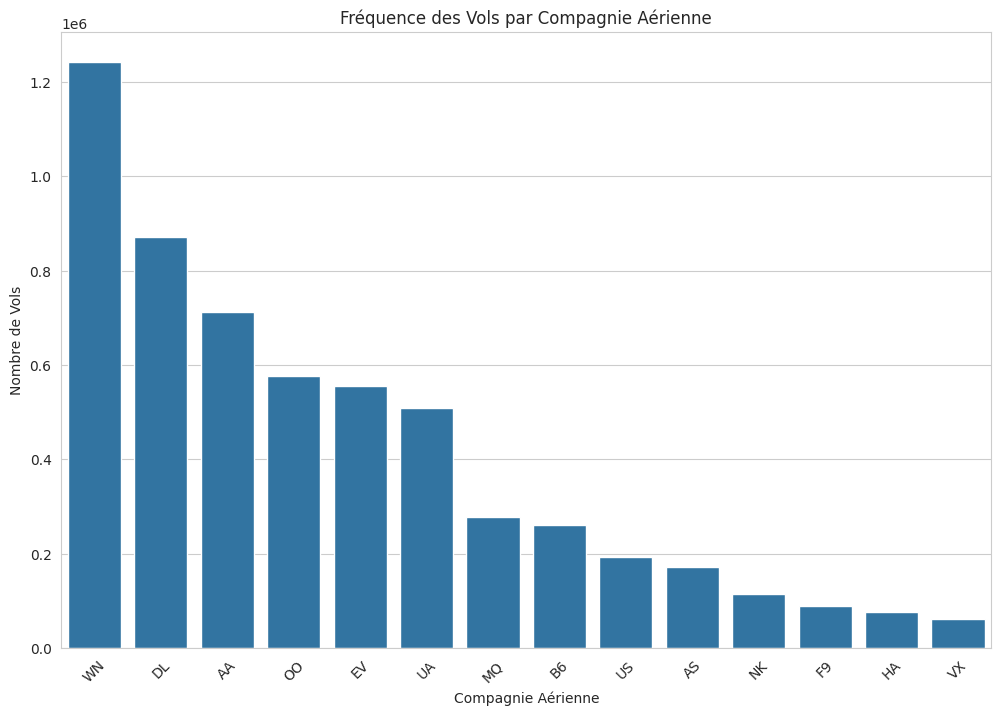

In [ ]:
sns.countplot(x='AIRLINE', data=df, order=df['AIRLINE'].value_counts().index)
plt.title('Fréquence des Vols par Compagnie Aérienne')
plt.xlabel('Compagnie Aérienne')
plt.ylabel('Nombre de Vols')
plt.xticks(rotation=45)
plt.savefig('frequency_by_airline.png')

## Génération du fichier SQL
Convertion du fichier CSV en fichier SQL pour l'importer dans la base de données Mysql pour le chatbot

In [5]:
def convert_csv_to_sql(dataframe, sql_file):
  """
  Convert a CSV file to an SQLite database and create a table.

  Args:
      data_frame (DataFrame): The dataframe.
      sql_file (str): The path to the SQLite database file.

  Returns:
      None
  """
  try:
    df = dataframe.copy()

    with open(sql_file, 'w') as f:
      for _, row in df.iterrows():
        sql = f"""INSERT INTO flights (YEAR, MONTH, DAY, DAY_OF_WEEK, AIRLINE, AIR_TIME, FLIGHT_NUMBER, ORIGIN_AIRPORT, DESTINATION_AIRPORT, SCHEDULED_DEPARTURE, SCHEDULED_ARRIVAL, SCHEDULED_TIME, DISTANCE, PREDICTED_PRICE)
        VALUES ({row['YEAR']}, {row['MONTH']}, {row['DAY']}, {row['DAY_OF_WEEK']}, '{row['AIRLINE']}', {row['AIR_TIME']}, {row['FLIGHT_NUMBER']}, '{row['ORIGIN_AIRPORT']}', '{row['DESTINATION_AIRPORT']}', '{row['SCHEDULED_DEPARTURE']}', '{row['SCHEDULED_ARRIVAL']}', {row['SCHEDULED_TIME']}, {row['DISTANCE']}, {row['PREDICTED_PRICE']});
        \n"""
        f.write(sql)
  except Exception as e:
    print(f"An error occurred: {e}")

In [6]:
convert_csv_to_sql(
  df[:150000],
  '/content/drive/MyDrive/ECOLE-IT/4DIA/reduced_dataset.sql'
)